In [17]:
import pandas as pd
import numpy as np

import torch
import numpy as np
import pandas as pd
import pickle
import multiprocessing
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


def get_cv_idxs(n, cv_idx=0, val_pct=0.2, seed=42):
    """ Get a list of index values for Validation set from a dataset

    Arguments:
        n : int, Total number of elements in the data set.
        cv_idx : int, starting index [idx_start = cv_idx*int(val_pct*n)]
        val_pct : (int, float), validation set percentage
        seed : seed value for RandomState

    Returns:
        list of indexes
    """
    np.random.seed(seed)
    n_val = int(val_pct * n)
    idx_start = cv_idx * n_val
    idxs = np.random.permutation(n)
    return idxs[idx_start:idx_start + n_val]


def split_by_idx(idxs, *a):
    """
    Split each array passed as *a, to a pair of arrays like this (elements selected by idxs,  the remaining elements)
    This can be used to split multiple arrays containing training data to validation and training set.

    :param idxs [int]: list of indexes selected
    :param a list: list of np.array, each array should have same amount of elements in the first dimension
    :return: list of tuples, each containing a split of corresponding array from *a.
            First element of each tuple is an array composed from elements selected by idxs,
            second element is an array of remaining elements.
    """
    mask = np.zeros(len(a[0]), dtype=bool)
    mask[np.array(idxs)] = True
    return [(o[mask], o[~mask]) for o in a]


class AutoEncoder(object):

    def __init__(self, data, validation_perc=0.2, lr=0.001,
                 intermediate_size=1000, encoded_size=100):

        # create training dataloader and validation tensor
        self.data = data
        self.val_idxs = get_cv_idxs(n=data.shape[0], val_pct=validation_perc)
        [(self.val, self.train)] = split_by_idx(self.val_idxs, data)
        self.dataset = AETrainingData(self.train)
        self.dataloader = DataLoader(self.dataset, batch_size=64, shuffle=True,
                                     num_workers=multiprocessing.cpu_count())
        #print('datal=',self.dataloader)
        self.val = torch.from_numpy(self.val.values).\
            type(torch.FloatTensor).cuda()

        # instantiate the encoder and decoder nets
        size = data.shape[1]
        self.encoder = Encoder(size, intermediate_size, encoded_size).cuda()
        self.decoder = Decoder(size, intermediate_size, encoded_size).cuda()

        # instantiate the optimizers
        self.encoder_optimizer = optim.Adam(
            self.encoder.parameters(), lr=lr, weight_decay=1e-8)
        self.decoder_optimizer = optim.Adam(
            self.decoder.parameters(), lr=lr, weight_decay=1e-8)

        # instantiate the loss criterion
        self.criterion = nn.MSELoss(reduction='mean')

        self.train_losses = []
        self.val_losses = []

    def train_step(self, input_tensor, target_tensor):
        # clear the gradients in the optimizers
        self.encoder_optimizer.zero_grad()
        self.decoder_optimizer.zero_grad()

        # Forward pass through
        encoded_representation = self.encoder(input_tensor)
        reconstruction = self.decoder(encoded_representation)

        # Compute the loss
        loss = self.criterion(reconstruction, target_tensor)

        # Compute the gradients
        loss.backward()

        # Step the optimizers to update the model weights
        self.encoder_optimizer.step()
        self.decoder_optimizer.step()

        # Return the loss value to track training progress
        return loss.item()
    
    def reset(self, train=True):
        # due to dropout the network behaves differently in training and
        # evaluation modes
        if train: self.encoder.train(); self.decoder.train()
        else: self.encoder.eval(); self.decoder.eval()

    def get_val_loss(self, input_tensor, target_tensor):
        self.reset(train=False)
        encoded = self.encoder(input_tensor)
        decoded = self.decoder(encoded)
        loss = self.criterion(decoded, target_tensor)
        return loss.item()

    def train_loop(self, epochs, print_every_n_batches=20):

        # Cycle through epochs
        for epoch in range(epochs):
            print(f'Epoch {epoch + 1}/{epochs}')

            # Cycle through batches
            for i, batch in enumerate(self.dataloader):
                #print(i,batch)
                
                self.reset(train=True)

                input_tensor = batch['input'].cuda()
                target_tensor = batch['target'].cuda()

                loss = self.train_step(input_tensor, target_tensor)

                if i % print_every_n_batches == 0 and i != 0:
                    #print('i=',i)
                    val_loss = self.get_val_loss(self.val, self.val)
                    print(f'train loss: {round(loss, 8)} | ' +
                          f'validation loss: {round(val_loss, 8)}')
                    self.train_losses.append(loss)
                    self.val_losses.append(val_loss)

    def get_encoded_representations(self):
        to_encode = torch.from_numpy(self.data.values).type(
            torch.FloatTensor).cuda()
        self.reset(train=False)
        encodings = self.encoder(to_encode).cpu().data.numpy()
        return encodings
    
    def get_decoded_representations(self):
        to_encode = torch.from_numpy(self.data.values).type(
            torch.FloatTensor).cuda()
        self.reset(train=False)
        encodings = self.encoder(to_encode).cpu().data.numpy()
        encodings=pd.DataFrame(encodings)
        to_decode = torch.from_numpy(encodings.values).type(
            torch.FloatTensor).cuda()
        self.reset(train=False)
        decodings = self.decoder(to_decode).cpu().data.numpy()
        return decodings


class AETrainingData(Dataset):
    """
    Format the training dataset to be input into the auto encoder.
    Takes in dataframe and converts it to a PyTorch Tensor
    """

    def __init__(self, x_train):
        self.x = x_train

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        """
        Returns a example from the data set as a pytorch tensor.
        """
        # Get example/target pair at idx as numpy arrays
        x, y = self.x.iloc[idx].values, self.x.iloc[idx].values

        # Convert to torch tensor
        x = torch.from_numpy(x).type(torch.FloatTensor)
        y = torch.from_numpy(y).type(torch.FloatTensor)

        # Return pair
        return {'input': x, 'target': y}


class Encoder(nn.Module):
    def __init__(self, input_size, intermediate_size, encoding_size):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, intermediate_size),
            nn.BatchNorm1d(intermediate_size),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(intermediate_size, encoding_size),
            nn.BatchNorm1d(encoding_size),
            nn.ReLU(True),
            nn.Dropout(0.2))

    def forward(self, x):
        x = self.encoder(x)
        return x


class Decoder(nn.Module):
    def __init__(self, output_size, intermediate_size, encoding_size):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Linear(encoding_size, intermediate_size),
            nn.BatchNorm1d(intermediate_size),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(intermediate_size, output_size),
            nn.BatchNorm1d(output_size),
            nn.Sigmoid())

    def forward(self, x):
        x = self.decoder(x)
        return x


In [2]:
with open(f'new_df_matrix.pkl', 'rb') as fh:
    new_df1 = pickle.load(fh)

In [3]:
ndf=new_df1

In [4]:
ndf=ndf.apply(lambda x: x/x.max(), axis=0)

In [6]:
ae3 = AutoEncoder(ndf, validation_perc=0.1, lr=1e-3, intermediate_size=1000, encoded_size=100)

In [7]:
ae3.train_loop(epochs=100)

Epoch 1/100
train loss: 0.2204162 | validation loss: 0.24042477
train loss: 0.2196801 | validation loss: 0.20850734
train loss: 0.21579306 | validation loss: 0.21432506
train loss: 0.21194659 | validation loss: 0.19928983
train loss: 0.20568003 | validation loss: 0.19519441
train loss: 0.2056392 | validation loss: 0.19245063
train loss: 0.18987058 | validation loss: 0.1884467
Epoch 2/100
train loss: 0.18659057 | validation loss: 0.18103999
train loss: 0.18306506 | validation loss: 0.18296656
train loss: 0.18250744 | validation loss: 0.16933347
train loss: 0.1761297 | validation loss: 0.16672321
train loss: 0.16873774 | validation loss: 0.16767709
train loss: 0.1674864 | validation loss: 0.16576064
train loss: 0.16752411 | validation loss: 0.15693963
Epoch 3/100
train loss: 0.1676172 | validation loss: 0.14956467
train loss: 0.15484472 | validation loss: 0.15105516
train loss: 0.1479459 | validation loss: 0.15822667
train loss: 0.15357243 | validation loss: 0.14148432
train loss: 0.1461

In [8]:
losses2 = pd.DataFrame(data=list(zip(ae3.train_losses, ae3.val_losses)), columns=['train_loss', 'validation_loss'])
losses2['epoch'] = (losses2.index + 1) / 3

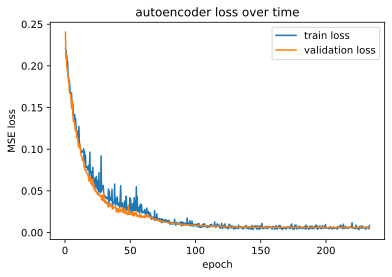

In [9]:
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg'
fig, ax = plt.subplots()
ax.plot(losses2['epoch'], losses2['train_loss'], label='train loss')
ax.plot(losses2['epoch'], losses2['validation_loss'], label='validation loss')
ax.set_ylabel('MSE loss')
ax.set_xlabel('epoch')
ax.set_title('autoencoder loss over time')
ax.legend()

In [11]:
losses2.to_csv('coll_loss_1.csv')

In [5]:
ae2 = AutoEncoder(ndf, validation_perc=0.1, lr=1e-2, intermediate_size=1000, encoded_size=100)

In [6]:
ae2.train_loop(epochs=100)

Epoch 1/100
train loss: 0.18060729 | validation loss: 0.21784297
train loss: 0.15019178 | validation loss: 0.14880985
train loss: 0.11760774 | validation loss: 0.10709476
train loss: 0.09392387 | validation loss: 0.09371503
train loss: 0.07915293 | validation loss: 0.07463454
train loss: 0.06720608 | validation loss: 0.06600042
train loss: 0.09688913 | validation loss: 0.05790672
Epoch 2/100
train loss: 0.05469299 | validation loss: 0.04544879
train loss: 0.04595901 | validation loss: 0.0446731
train loss: 0.04298977 | validation loss: 0.03439213
train loss: 0.04233389 | validation loss: 0.03906492
train loss: 0.03601425 | validation loss: 0.03189223
train loss: 0.04601734 | validation loss: 0.02748308
train loss: 0.04397296 | validation loss: 0.02639109
Epoch 3/100
train loss: 0.0304297 | validation loss: 0.02190709
train loss: 0.02991363 | validation loss: 0.02945017
train loss: 0.02656911 | validation loss: 0.02245033
train loss: 0.03931882 | validation loss: 0.02078692
train loss: 

In [7]:
losses3 = pd.DataFrame(data=list(zip(ae2.train_losses, ae2.val_losses)), columns=['train_loss', 'validation_loss'])
losses3['epoch'] = (losses3.index + 1) / 3

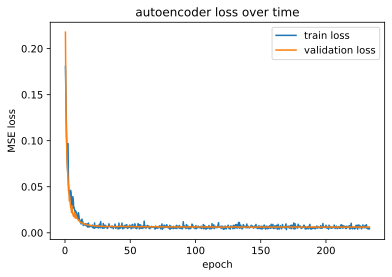

In [8]:
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg'
fig, ax = plt.subplots()
ax.plot(losses3['epoch'], losses3['train_loss'], label='train loss')
ax.plot(losses3['epoch'], losses3['validation_loss'], label='validation loss')
ax.set_ylabel('MSE loss')
ax.set_xlabel('epoch')
ax.set_title('autoencoder loss over time')
ax.legend()

In [9]:
losses3.to_csv('coll_loss_2.csv')

In [10]:
encoded_2 = ae2.get_encoded_representations()

In [11]:
with open('autoencodercoll_embeddings2.pkl', 'wb') as fh:
    pickle.dump(encoded_2, fh)

In [5]:
ae1 = AutoEncoder(ndf, validation_perc=0.1, lr=1e-4, intermediate_size=1000, encoded_size=100)

In [6]:
ae1.train_loop(epochs=100)

Epoch 1/100
train loss: 0.24763145 | validation loss: 0.24518825
train loss: 0.233201 | validation loss: 0.22472897
train loss: 0.22709592 | validation loss: 0.21175322
train loss: 0.23428787 | validation loss: 0.21635716
train loss: 0.22749078 | validation loss: 0.21694338
train loss: 0.22580776 | validation loss: 0.21480174
train loss: 0.22852704 | validation loss: 0.21771002
Epoch 2/100
train loss: 0.22785686 | validation loss: 0.21675099
train loss: 0.22557388 | validation loss: 0.2142226
train loss: 0.22109887 | validation loss: 0.21554072
train loss: 0.22291918 | validation loss: 0.210242
train loss: 0.22262408 | validation loss: 0.21294326
train loss: 0.22357771 | validation loss: 0.21729763
train loss: 0.22058329 | validation loss: 0.21296987
Epoch 3/100
train loss: 0.21957876 | validation loss: 0.22117536
train loss: 0.22201827 | validation loss: 0.21427883
train loss: 0.22048 | validation loss: 0.21229915
train loss: 0.22434834 | validation loss: 0.21613088
train loss: 0.2178

In [7]:
losses4 = pd.DataFrame(data=list(zip(ae1.train_losses, ae1.val_losses)), columns=['train_loss', 'validation_loss'])
losses4['epoch'] = (losses4.index + 1) / 3

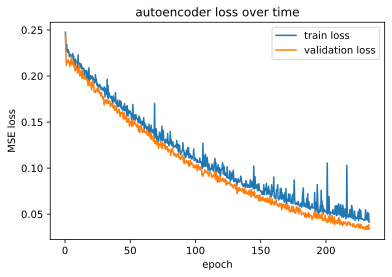

In [8]:
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg'
fig, ax = plt.subplots()
ax.plot(losses4['epoch'], losses4['train_loss'], label='train loss')
ax.plot(losses4['epoch'], losses4['validation_loss'], label='validation loss')
ax.set_ylabel('MSE loss')
ax.set_xlabel('epoch')
ax.set_title('autoencoder loss over time')
ax.legend()

In [9]:
losses4.to_csv('coll_loss_3.csv')

In [5]:
ae5 = AutoEncoder(ndf, validation_perc=0.1, lr=1e-5, intermediate_size=1000, encoded_size=100)

In [6]:
ae5.train_loop(epochs=100)

Epoch 1/100
train loss: 0.26814017 | validation loss: 0.24561402
train loss: 0.26577559 | validation loss: 0.24658194
train loss: 0.25993568 | validation loss: 0.24379219
train loss: 0.25260454 | validation loss: 0.24287409
train loss: 0.24893533 | validation loss: 0.23794076
train loss: 0.24077445 | validation loss: 0.23039894
train loss: 0.24682286 | validation loss: 0.22788453
Epoch 2/100
train loss: 0.24402212 | validation loss: 0.22644053
train loss: 0.23802918 | validation loss: 0.22379693
train loss: 0.23481013 | validation loss: 0.22470248
train loss: 0.23440462 | validation loss: 0.22471695
train loss: 0.23712108 | validation loss: 0.21820107
train loss: 0.23564498 | validation loss: 0.22367159
train loss: 0.23245287 | validation loss: 0.22541887
Epoch 3/100
train loss: 0.23155828 | validation loss: 0.22044367
train loss: 0.23209682 | validation loss: 0.22352584
train loss: 0.23294951 | validation loss: 0.22262861
train loss: 0.22440936 | validation loss: 0.21809167
train loss

In [7]:
losses5 = pd.DataFrame(data=list(zip(ae5.train_losses, ae5.val_losses)), columns=['train_loss', 'validation_loss'])
losses5['epoch'] = (losses5.index + 1) / 3

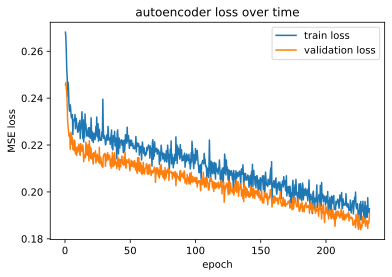

In [8]:
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg'
fig, ax = plt.subplots()
ax.plot(losses5['epoch'], losses5['train_loss'], label='train loss')
ax.plot(losses5['epoch'], losses5['validation_loss'], label='validation loss')
ax.set_ylabel('MSE loss')
ax.set_xlabel('epoch')
ax.set_title('autoencoder loss over time')
ax.legend()

In [9]:
losses5.to_csv('coll_loss_4.csv')

In [10]:
l1=pd.read_csv('coll_loss_1.csv')
l2=pd.read_csv('coll_loss_2.csv')
l3=pd.read_csv('coll_loss_3.csv')
l4=pd.read_csv('coll_loss_4.csv')

Text(0.5, 1.0, 'Autoencoder loss for Training')

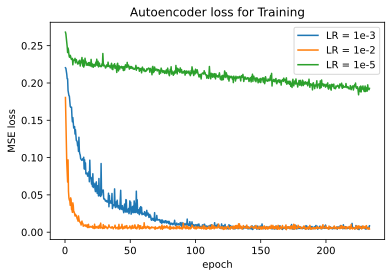

In [13]:
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg'
fig, ax = plt.subplots()
ax.plot(l1['epoch'], l1['train_loss'], label = "LR = 1e-3")

ax.plot(l2['epoch'], l2['train_loss'], label = "LR = 1e-2")

ax.plot(l4['epoch'], l4['train_loss'], label = "LR = 1e-5")

ax.set_ylabel('MSE loss')
ax.set_xlabel('epoch')
ax.legend()
ax.set_title('Autoencoder loss for Training')

Text(0.5, 1.0, 'Autoencoder loss for Validation')

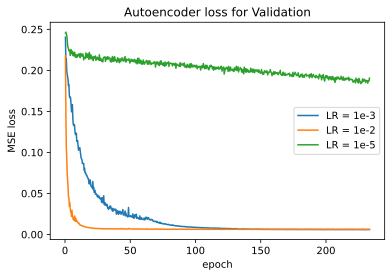

In [12]:
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg'
fig, ax = plt.subplots()

ax.plot(l1['epoch'], l1['validation_loss'], label = "LR = 1e-3")

ax.plot(l2['epoch'], l2['validation_loss'], label = "LR = 1e-2")

ax.plot(l4['epoch'], l4['validation_loss'], label = "LR = 1e-5")


ax.set_ylabel('MSE loss')
ax.set_xlabel('epoch')
ax.legend()
ax.set_title('Autoencoder loss for Validation')

In [3]:
#ndf2=ndf.T

In [4]:
#ndf2.shape

In [5]:
#ndf2=ndf2.sample(500)

In [6]:
#ae8 = AutoEncoder(ndf2, validation_perc=0.1, lr=1e-3, intermediate_size=1000, encoded_size=100)

In [7]:
#ae8.train_loop(epochs=1)

In [8]:
#encoded_8 = ae8.get_encoded_representations()

In [9]:
#encoded_8

In [23]:
#decoded_8 = ae8.get_decoded_representations()

In [2]:
#decoded_8

In [1]:
#decoded_8.shape

#d8=ae8.decoder(ndf3)